In [0]:
#Link to google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#This will take around 2 to 4 minutes, depends on the internet
import zipfile

# please change the path to match with the path in your google drive
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/PhD SU/Semester 1/deep learning/homework/HW2/img_align_celeba.zip', 'r')
zip_ref.extractall()
zip_ref.close()

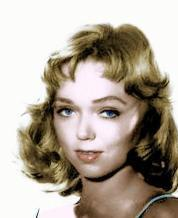

In [0]:
# Display sample image from CELEBA

from IPython.display import Image
Image('img_align_celeba/202599.jpg')


In [0]:
import pandas as pd
import numpy as np
import os
import keras
from keras.layers import Dense,GlobalAveragePooling2D,Flatten,Dropout
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential,load_model
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt


save_path = '/content/gdrive/My Drive/PhD SU/Semester 1/deep learning/homework/HW2/'


In [0]:
column_names = ['filenames','labels']
train_data = pd.read_csv(save_path +'CELEBATrain.txt', sep=" ", header=None, 
              names=column_names, dtype={'filenames':str,'labels':str})
val_data = pd.read_csv(save_path +'CELEBAVal.txt', sep=" ", header=None, 
              names=column_names, dtype={'filenames':str,'labels':str})

datagen_train=ImageDataGenerator(rescale=1./255,
              shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True)

datagen_val=ImageDataGenerator(rescale=1./255)

train_iter=datagen_train.flow_from_dataframe(
          dataframe=train_data,
          directory='./img_align_celeba/',
          x_col='filenames',
          y_col='labels',
          batch_size = 32,
          class_mode='categorical',
          target_size=(218,178))

val_iter=datagen_val.flow_from_dataframe(
          dataframe=val_data,
          directory='./img_align_celeba/',
          x_col='filenames',
          y_col='labels',
          batch_size = 32,    
          class_mode='categorical',
          target_size=(218,178))

step_size_train=train_iter.n//train_iter.batch_size
step_size_val=val_iter.n//val_iter.batch_size

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.


In [0]:
# base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, 
                   input_shape = (218, 178, 3))

my_model = Sequential()
my_model.add(base_model)
# my_model.add(GlobalAveragePooling2D())
my_model.add(Flatten())
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(2, activation='softmax'))

# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers[:-4]:
  layer.trainable = False

# my_model.compile(loss="categorical_crossentropy", optimizer="adam",
#                  metrics=["accuracy"])

my_model.compile(loss="categorical_crossentropy", 
                 optimizer = SGD(lr=0.0001,
                 momentum=0.9), metrics=["accuracy"])

print(my_model.summary())

# callbacks for recording losses per batch 
class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []
    

  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('acc'))
    self.val_acc.append(logs.get('val_acc'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 5, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 15360)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              15729664  
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 2050      
Total params: 30,446,402
Trainable params: 22,811,138
Non-trainable params: 7,635,264
_________________________________________________________________
None


In [0]:
history = LossHistory()
model_info = my_model.fit_generator(generator=train_iter,
                    validation_data=val_iter,steps_per_epoch=step_size_train,                                                        
                    validation_steps=step_size_val,epochs=1,verbose=1,
                    callbacks=[history])

acc = history.acc
val_acc = history.val_acc
loss = history.losses
val_loss = history.val_losses
 


Epoch 1/1
5086/5086 [==============================] - 3427s 674ms/step - loss: 0.1666 - acc: 0.9318 - val_loss: 0.0823 - val_acc: 0.9679


In [0]:
save_path = '/content/gdrive/My Drive/PhD SU/Semester 1/deep learning/homework/HW2/models/'
my_model.save(save_path + 'VGG16_model.h5')


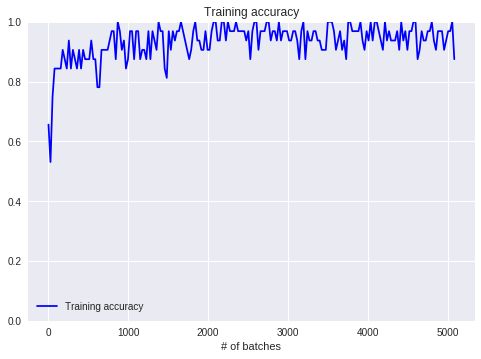

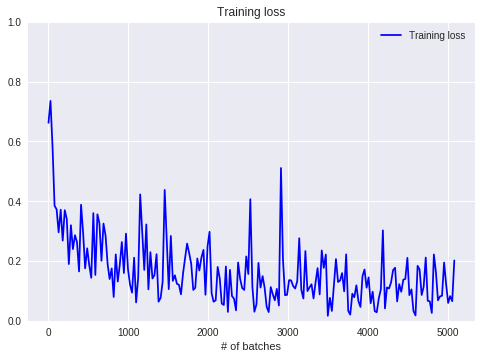

In [0]:
epochs = len(acc)
N = 200
acc_new = []
val_acc_new = []
loss_new = []
val_loss_new = []
xticks = np.linspace(0,epochs-1,N,dtype='int')

for idx in xticks:
  acc_new.append(acc[idx])
  val_acc_new.append(val_acc[idx])
  loss_new.append(loss[idx])
  val_loss_new.append(val_loss[idx])
        
plt.plot(xticks, acc_new, 'b', label='Training accuracy')
# plt.plot(xticks, val_acc_new, 'r', label='Validation accuracy')
plt.ylim(0., 1.)
plt.xlabel('# of batches')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(xticks, loss_new, 'b', label='Training loss')
# plt.plot(xticks, val_loss_new, 'r', label='Validation loss')
plt.ylim(0., 1.)
plt.xlabel('# of batches')
plt.title('Training loss')
plt.legend()
 
plt.show()